## BC2407 Project 

---

## <a id='content'>Table of Contents </a>
...

**Models (from proposal)**
- Association rules
- Quantile Regression
- MARS
- Random Forest 
- NN

...

**Business problem**:

1. Bundle service provision - to help increase sales revenue 
    - Association rules 
2. Customer Churn prediction
    - Logistic Regression 
    - Random Forest 
    - XG Boost 
    - NN
3. Feature importance (factors that lead to lower churn)
    - Univariant analysis (LR)
    - Multivariant analysis (RF)


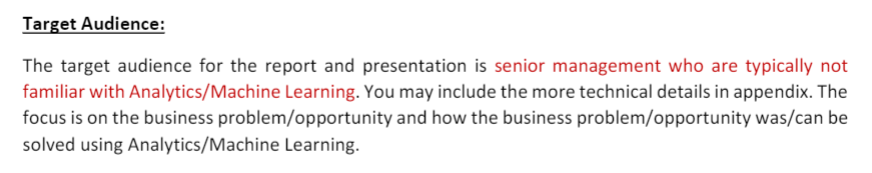

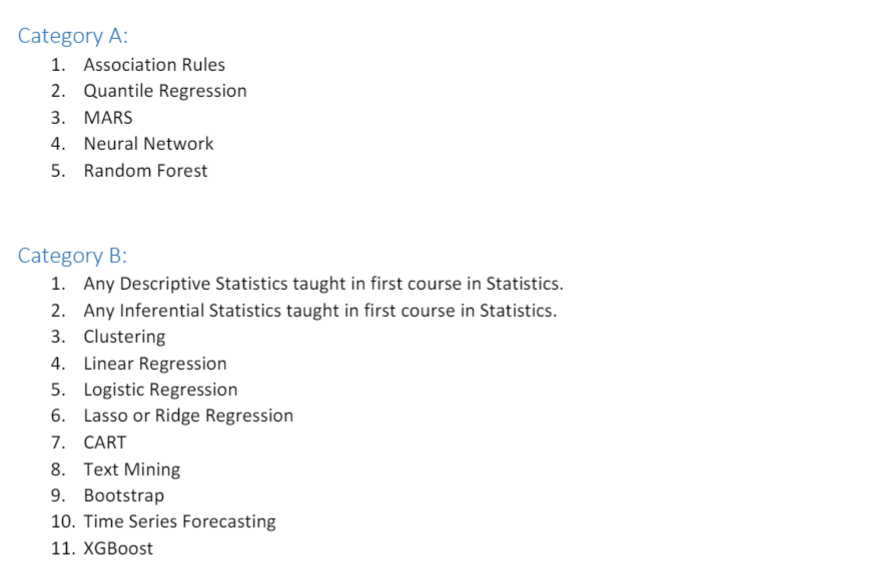

---

## 1. Data Preparation

**some useful info**

- **CLTV**: Customer Lifetime Value. 
    - A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.
    
- **Churn Score**: 
    - A value from 0-100 that is calculated using the predictive tool IBM SPSS Modeler. The model incorporates multiple factors known to cause churn. The higher the score, the more likely the customer will churn.
    
- **Churn Value**: 
    - 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label.

- **Referred a Friend**:
    - Indicates if the customer has ever referred a friend or family member to this company
    
- **Tenure in Months**:
    - Indicates the total amount of months that the customer has been with the company by the end of the quarter specified
    
- **Offer**:
    - Identifies the last marketing offer that the customer accepted, if applicable
    
- **Monthly Charge**:
    - Indicates the customer’s current total monthly charge for all their services from the company
    
- **Total Regular Charge**
    - Indicates the customer’s total regular charges, excluding additional charges

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import clear_output

import folium
from folium.plugins import MarkerCluster
from folium import Choropleth, Circle, Marker
from folium import plugins
from folium.plugins import HeatMap


%matplotlib inline

In [2]:
path = "data/"

# Note: - deal with total charges NA later
# useless_col = ['customerID','Payment Method','DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies']
useless_col = ['customerID','TechSupport','DeviceProtection','gender','ChurnValue',"TotalCharges"]
data1 = pd.read_csv(path+"Telco-Customer-Churn.csv",index_col=0)
data2 = pd.read_csv(path+"telco_churn_data.csv",index_col=0)
data2.columns = data2.columns.str.replace(" ",'')
col_to_merge = data2.columns.difference(data1.columns)
data_combined = data1.join(data2[col_to_merge])
data_combined = data_combined.reset_index().drop(useless_col,axis=1)
# data_combined.head()

In [3]:
# Check for NA values
for col in data_combined.columns:
    na_count = data_combined[col].isna().sum()
    if na_count>0:
        print(col, 'has',na_count,'missing values')

# Clean missing values 
data_combined = data_combined.drop(['ChurnCategory', 'ChurnReason','CustomerSatisfaction'], axis=1)
print("\nNumber of missing values in the cleaned dataset now: ",data_combined.isna().sum().sum())


ChurnCategory has 5174 missing values
ChurnReason has 5174 missing values
CustomerSatisfaction has 5209 missing values

Number of missing values in the cleaned dataset now:  0


In [4]:
data_combined = data_combined.replace("Yes", 1).replace("No", 0)
data_combined = data_combined.replace("Male", 1).replace("Female", 0)
data_combined['InternetService'] = data_combined['InternetService'].replace('DSL',1)
data_combined['InternetService'] = data_combined['InternetService'].replace('Fiber optic',1)
data_combined['InternetType'] = data_combined['InternetType'].replace('None','NA')

In [5]:
# data_combined[data_combined['Internet Service']==0]

In [6]:
# data_combined[data_combined['Phone Service']==0]

#### Generating useful variables

In [7]:
geographical_col = ['Latitude','ZipCode','Longitude','City']
data_filtered = data_combined.copy()
data_filtered = data_filtered.drop(geographical_col,axis=1)

In [8]:
def get_data_info(data_df:pd.DataFrame, data_filtered:pd.DataFrame=None):
    data_col = data_df.columns.tolist()
    data_info = pd.DataFrame(index=data_df.columns,columns=['dtype','unique_ct','eg1','eg2'])
    for col in data_col:
        data_info.loc[col,'dtype'] = data_df[col].dtype
        data_info.loc[col,'unique_ct'] = len(data_df[col].unique())
        data_info.loc[col,'eg1'] = data_df[col][0]
        data_info.loc[col,'eg2'] = data_df[col][1]
    data_info=data_info.sort_values('unique_ct',ascending=False)
    return data_info

In [9]:
data_info = get_data_info(data_filtered)

cat_col_binary_orig = data_info[data_info['unique_ct']<=2].index.tolist()
cat_col_multi = data_info[(data_info['unique_ct']<=6)&(data_info['unique_ct']>2)].index.tolist()
continuous_col = data_info[data_info['unique_ct']>6].index.tolist()

cat_col_binary_exceptions = []
for col in cat_col_multi.copy():
    print('\nChecking Value for: ', col)
    unique_val = data_combined[col].unique().tolist()
    print(unique_val)
    if 'No internet service' in unique_val or('No phone service' in unique_val):
        cat_col_multi.remove(col)
        cat_col_binary_exceptions.append(col)
        
cat_col_binary = cat_col_binary_orig+cat_col_binary_exceptions

print("\n\033[1mBinary Categorical Columns are: \033[0m\n",cat_col_binary)
# print("\n\033[1mBinary Categorical Columns (with exceptions) are: \033[0m\n",cat_col_binary_exceptions)
print("\n\033[1mMulti Categorical Columns are:\033[0m \n",cat_col_multi)
print("\n\033[1mContinuous Columns are:\033[0m \n",continuous_col)


Checking Value for:  Offer
['Offer E', 'None', 'Offer D', 'Offer C', 'Offer B', 'Offer A']

Checking Value for:  InternetType
['Fiber Optic', 'DSL', 'Cable', 'NA']

Checking Value for:  PaymentMethod
['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']

Checking Value for:  Contract
['Month-to-month', 'One year', 'Two year']

Checking Value for:  StreamingMovies
[0, 1, 'No internet service']

Checking Value for:  StreamingTV
[0, 1, 'No internet service']

Checking Value for:  OnlineBackup
[1, 0, 'No internet service']

Checking Value for:  OnlineSecurity
[0, 1, 'No internet service']

Checking Value for:  MultipleLines
['No phone service', 0, 1]

Binary Categorical Columns are: 
 ['SeniorCitizen', 'StreamingMusic', 'Under30', 'ReferredaFriend', 'DeviceProtectionPlan', 'PremiumTechSupport', 'Married', 'Gender', 'Partner', 'Churn', 'PaperlessBilling', 'InternetService', 'PhoneService', 'Dependents', 'UnlimitedData', 'StreamingMovies', 'StreamingTV

In [10]:
# data_combined["TotalCharges"] = data_combined["TotalCharges"].astype("float")
data_combined[cat_col_binary+cat_col_multi] = data_combined[cat_col_binary+cat_col_multi].astype('category')
# get_data_info(data_combined)

In [11]:
# Encoding categorical Variables 
encoded_cols=[]
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    encoded_cols.extend(dummies.columns.tolist())
    res = res.drop([feature_to_encode], axis=1) 
    return(res)

    
data_encoded = data_combined.copy()
for col in cat_col_multi:
    print("Encoding variable" ,col)
    data_encoded = encode_and_bind(data_encoded,col)
encoded_cols=list(set(encoded_cols))
print("\nEncoded columns: ",encoded_cols)

# data_encoded.head()

Encoding variable Offer
Encoding variable InternetType
Encoding variable PaymentMethod
Encoding variable Contract

Encoded columns:  ['Offer_Offer A', 'Offer_Offer E', 'InternetType_NA', 'InternetType_Fiber Optic', 'PaymentMethod_Bank transfer (automatic)', 'Contract_One year', 'Contract_Two year', 'Offer_Offer D', 'Offer_Offer B', 'Offer_Offer C', 'Offer_None', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Mailed check', 'InternetType_DSL', 'Contract_Month-to-month', 'PaymentMethod_Electronic check', 'InternetType_Cable']


In [12]:
data_combined.to_csv("data_combined.csv")

---

## 2. Data Exploration 

In [13]:
######################################################

### PLACEHOLDER ###

######################################################

In [77]:
def PlotLocations(data):
    data['Latitude'] = data['Latitude'].astype(float)
    data['Longitude'] = data['Longitude'].astype(float)
    m_3 = folium.Map(location=[33.964131,-118.272783], tiles='cartodbpositron', zoom_start=13)

    mc = MarkerCluster()
    for idx, row in data.iterrows():
        if not math.isnan(row['Longitude']) and not math.isnan(row['Latitude']):
            mc.add_child(Marker([row['Latitude'], row['Longitude']]))
    m_3.add_child(mc)
    
    data_churn = data[data['Churn'] == '1']
    data_churn = data_churn[['Latitude', 'Longitude']]
    data_churn = data_churn.dropna(axis=0, subset=['Latitude','Longitude'])
    heat_data = [[row['Latitude'],row['Longitude']] for index, row in data_churn.iterrows()]

    HeatMap(heat_data).add_to(m_3)

    return m_3

PlotLocations(data_combined)

---

## 3. Models

In [68]:
# Utils functions 
from sklearn.metrics import confusion_matrix

def plot_cm(
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
    
    model_name="",
    
    linewidths=.5,
    cmap="YlGnBu"
):
    cm_train = confusion_matrix( y_train,y_train_pred)
    cm_test = confusion_matrix( y_test,y_test_pred)
    accuracy_train = (cm_train[0,0]+cm_train[1,1])/sum(sum(cm_train))
    accuracy_test = (cm_test[0,0]+cm_test[1,1])/sum(sum(cm_test))
    
    print("Train set accuracy (in%):", "{:.2f}%".format(accuracy_train*100))
    print("Test set accuracy (in%):", "{:.2f}%".format(accuracy_test*100))
    print()
    
    group_names = ['TN','FP','FN','TP']
    group_perc_train = ["{0:.2%}".format(value) for value in
                                    cm_train.flatten()/np.sum(cm_train)]
    group_perc_test = ["{0:.2%}".format(value) for value in
                                    cm_test.flatten()/np.sum(cm_test)]
    labels_train = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_perc_train)]
    labels_test = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_perc_test)]
    labels_train = np.asarray(labels_train).reshape(2,2)
    labels_test = np.asarray(labels_test).reshape(2,2)
    
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3))

    sns.heatmap(cm_train, ax=ax1,fmt='',
                            annot=labels_train,linewidths=linewidths,cmap=cmap)
    ax1.set_xlabel('Predicted "Churn" status')
    ax1.set_ylabel('Actual "Churn" status') 
    ax1.set_title(model_name+'Confusion Matrix (Train)\n\n Accuracy: ' + "{:.2f}%".format(accuracy_train*100) + "\n") 
    ax1.xaxis.set_ticklabels(['0', '1'])
    ax1.yaxis.set_ticklabels(['0', '1'])

    sns.heatmap(cm_test, ax=ax2,fmt='',
                           annot=labels_test,linewidths=linewidths,cmap=cmap);
    ax2.set_xlabel('Predicted "default" status')
    ax2.set_ylabel('Actual "default" status')
    ax2.set_title(model_name+'Confusion Matrix (Test)\n\n Accuracy: ' + "{:.2f}%".format(accuracy_test*100) + "\n")
    ax2.xaxis.set_ticklabels(['0', '1'])
    ax2.yaxis.set_ticklabels(['0', '1'])
    
def get_cm_accuracy(
        y_train,
        y_train_pred,
        y_test,
        y_test_pred,
):
        cm_train = confusion_matrix( y_train,y_train_pred)
        cm_test = confusion_matrix( y_test,y_test_pred)
        accuracy_train = (cm_train[0,0]+cm_train[1,1])/sum(sum(cm_train))
        accuracy_test = (cm_test[0,0]+cm_test[1,1])/sum(sum(cm_test))
        
        return accuracy_train,accuracy_test
    
def plot_barh(
    data:pd.DataFrame,
    column_to_plot:str,
    title="",
    figsize=(8,3),
    title_size=18,
    label_size=14,
    style="bmh"
):
    plt.style.use(style)
    data_plot = data.copy()
    data_plot = data_plot.sort_values(column_to_plot,ascending=True)
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(data_plot.index,data_plot[column_to_plot])
    ax.xaxis.set_tick_params(labelsize=label_size)
    ax.yaxis.set_tick_params(labelsize=label_size)
    ax.set_title(title, size=title_size)

### Association Rules

It is a rule-based machine learning technique used to find patterns (relationships, structures) in the data.

Association rules will help us determine the services customers often order in tandem. Baskets of services be formed based on the minimum confidence, support and lift that we specify. We will be using a dataset which contains the list of services purchased at supermarkets by different customers for this analysis.

**Business Problem**

Potentially to provide bundle promotion to increase sales

In [33]:
phone_serivces = ['PhoneService','MultipleLines']
internet_services = ['InternetService','InternetType','UnlimitedData', 
                            'StreamingTV', 'StreamingMovies', 'StreamingMusic'
                             'OnlineSecurity','OnlineBackup',
                            'DeviceProtectionPlan','PremiumTechSupport']
other_services = ['PaperlessBilling','Contract']

internet_services_encoded=['InternetService','UnlimitedData', 'InternetType_NA',
                            'InternetType_DSL', 'InternetType_Cable', 'InternetType_Fiber Optic',
                            'StreamingTV', 'StreamingMovies', 'StreamingMusic',
                             'OnlineSecurity','OnlineBackup',
                            'DeviceProtectionPlan','PremiumTechSupport']

other_services_encoded=['PaperlessBilling',
                       'Contract_Two year','Contract_One year','Contract_Month-to-month']

# omitted variables: Offer, PaymentMethod
# multicat = ['Offer', 'PaymentMethod', 'InternetType', 'Contract']

all_services = phone_serivces+internet_services+other_services
all_services_encoded = phone_serivces+internet_services_encoded+other_services_encoded

In [161]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

min_sup=0.4
min_thres=0.4

print("Settings: ")
print("min_support: ", min_sup)
print("min_thres: ", min_thres)

Settings: 
min_support:  0.4
min_thres:  0.4


In [163]:
# Assoc Rule for all services
assoc_rule_data_all = data_encoded[all_services_encoded]
assoc_rule_data_all = assoc_rule_data_all.replace('No internet service',0)
assoc_rule_data_all = assoc_rule_data_all.replace('No phone service',0)
item_all = apriori(assoc_rule_data_all, use_colnames=True, min_support=min_sup)
assoc_rule_all = association_rules(item_all, metric = 'confidence', min_threshold=min_thres)

# Assoc Rule for Internet service
assoc_rule_data_internet = data_encoded[data_encoded['InternetService']==1][internet_services_encoded]
assoc_rule_data_internet = assoc_rule_data_internet.drop('InternetType_NA',axis=1)
item_internet = apriori(assoc_rule_data_internet, use_colnames=True, min_support=min_sup)
assoc_rule_internet = association_rules(item_internet, metric = 'confidence', min_threshold=min_thres)

# Assoc Rule for Internet service + others (paperless billing & contract)
assoc_rule_data_internet_others = data_encoded[data_encoded['InternetService']==1][internet_services_encoded+other_services_encoded]
assoc_rule_data_internet_others = assoc_rule_data_internet_others.drop('InternetType_NA',axis=1)
item_internet_others = apriori(assoc_rule_data_internet_others, use_colnames=True, min_support=min_sup)
assoc_rule_internet_others = association_rules(item_internet_others, metric = 'confidence', min_threshold=min_thres)

# Assoc Rule for phone service + others (paperless billing & contract)
assoc_rule_data_phone_others = data_encoded[data_encoded['PhoneService']==1][phone_serivces+other_services_encoded]
item_phone_others = apriori(assoc_rule_data_phone_others, use_colnames=True, min_support=min_sup)
assoc_rule_phone_others = association_rules(item_phone_others, metric = 'confidence', min_threshold=min_thres)

In [173]:
## Results DF Analysis - based on lift 
assoc_rule_all = assoc_rule_all.sort_values("lift",ascending=False)
assoc_rule_internet  = assoc_rule_internet .sort_values("lift",ascending=False)
assoc_rule_internet_others  = assoc_rule_internet_others .sort_values("lift",ascending=False)
assoc_rule_phone_others  = assoc_rule_phone_others .sort_values("lift",ascending=False)

In [174]:
assoc_rule_all.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
17,(PaperlessBilling),"(InternetService, PhoneService)",0.592219,0.686497,0.473946,0.800288,1.165755,0.067389,1.569772
12,"(InternetService, PhoneService)",(PaperlessBilling),0.686497,0.592219,0.473946,0.690383,1.165755,0.067389,1.317047
8,(InternetService),(PaperlessBilling),0.783331,0.592219,0.528894,0.675186,1.140094,0.064990,1.255428
9,(PaperlessBilling),(InternetService),0.592219,0.783331,0.528894,0.893071,1.140094,0.064990,2.026293
14,"(PaperlessBilling, PhoneService)",(InternetService),0.537271,0.783331,0.473946,0.882135,1.126134,0.053085,1.838286


### Logistic Regression 


Prediction of Customer Churn

In [60]:
data_LR = data_encoded.copy()
data_LR = data_LR.drop(geographical_col,axis=1)
data_LR = data_LR.replace("No internet service",0)
data_LR = data_LR.replace("No phone service",0)

dependent_var = ['Churn','CLTV']
independent_var = data_LR.columns.tolist()
independent_var.remove('Churn')
independent_var.remove('CLTV')

In [66]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model

LR_X = data_LR[independent_var]
LR_y = data_LR['Churn']
LR_X_train, LR_X_test, LR_y_train, LR_y_test = train_test_split(LR_X, LR_y, train_size=0.8,
                                                                                                random_state=2022)
LR_model = linear_model.LogisticRegression()
LR_model.fit(LR_X_train, LR_y_train)
LR_pred_train = LR_model.predict(LR_X_train)
LR_pred_test = LR_model.predict( LR_X_test)   

LR_train_acc, LR_test_acc = get_cm_accuracy(LR_y_train,LR_pred_train,LR_y_test,LR_pred_test,)

C:\Users\Yakun\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train set accuracy (in%): 78.70%
Test set accuracy (in%): 79.49%



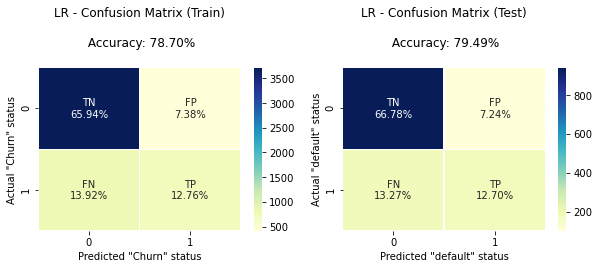

In [70]:
plot_cm(LR_y_train,LR_pred_train,LR_y_test,LR_pred_test,model_name="LR - ")

### Random Forest

Prediction of Customer Churn


In [37]:
data_RF = data_encoded.copy()
data_RF = data_RF.drop(geographical_col,axis=1)
data_RF = data_RF.replace("No internet service",0)
data_RF = data_RF.replace("No phone service",0)

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

RF_X = data_RF[independent_var]
RF_y = data_RF['Churn']
RF_X_train, RF_X_test, RF_y_train, RF_y_test = train_test_split(RF_X, RF_y, train_size=0.8,
                                                                                                random_state=2022)

RF_model = RandomForestClassifier(n_estimators=500,
                                                             random_state=2022)
RF_model.fit(RF_X_train, RF_y_train)
RF_pred_train = RF_model.predict(RF_X_train)
RF_pred_test = RF_model.predict(RF_X_test)      

RF_train_acc, RF_test_acc = get_cm_accuracy(RF_y_train,RF_pred_train,RF_y_test,RF_pred_test)

Train set accuracy (in%): 100.00%
Test set accuracy (in%): 90.49%



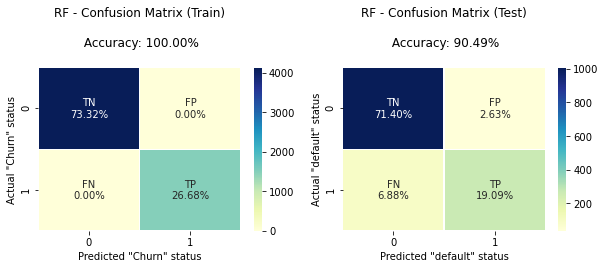

In [69]:
plot_cm(RF_y_train,RF_pred_train,RF_y_test,RF_pred_test,model_name="RF - ")

<p style="color:firebrick;font-weight: bold"> ^^Here, we see that there is a problem of overfitting </p>


In [ ]:
# Mitigate overfitting 
# Optimization 

**RF - Feature importance analysis**

In [ ]:
# Feature importance  
from sklearn.inspection import permutation_importance
import time

start_time = time.time()
RF_result = permutation_importance(
    RF_model, RF_X_train, RF_y_train, 
    random_state=2022
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

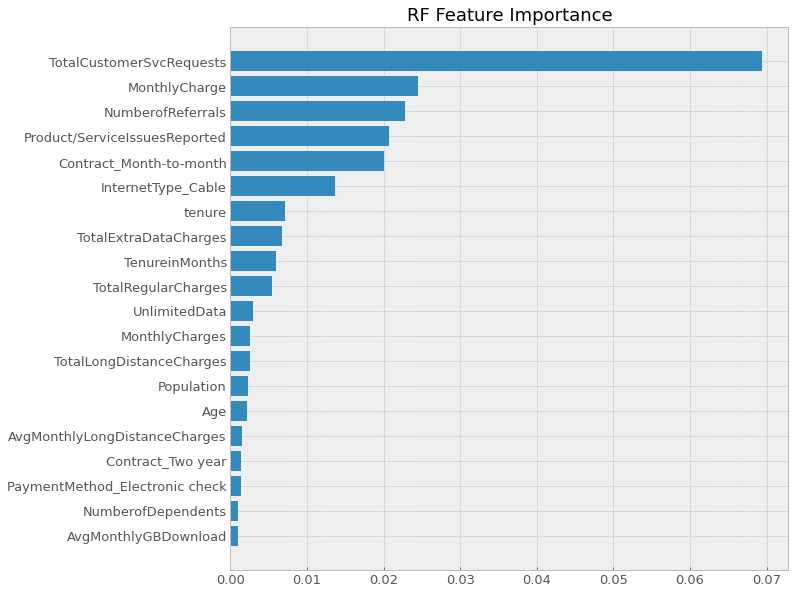

In [159]:
# Visualize
RF_feature_impt = pd.Series(RF_result.importances_mean, index=XGB_X.columns)
RF_feature_impt = RF_feature_impt .sort_values(ascending=False).to_frame("Feature importance")

plot_barh(RF_feature_impt.head(20),
                column_to_plot = 'Feature importance',
                title = "RF Feature Importance",
                figsize=(10,10),
                title_size=18,
                label_size=13,
                style="bmh"
         )

### XGBoost (standard)

In [81]:
data_XGB = data_encoded.copy()
data_XGB = data_XGB.drop(geographical_col,axis=1)
data_XGB = data_XGB.replace("No internet service",0)
data_XGB = data_XGB.replace("No phone service",0)

In [82]:
from sklearn.ensemble import GradientBoostingClassifier

XGB_X = data_XGB[independent_var]
XGB_y = data_XGB['Churn']
XGB_X_train, XGB_X_test, XGB_y_train, XGB_y_test = train_test_split(XGB_X, XGB_y, train_size=0.8,
                                                                                                random_state=2022)

XGB_model = GradientBoostingClassifier()
XGB_model.fit(XGB_X_train, XGB_y_train)
XGB_pred_train = XGB_model.predict(XGB_X_train)
XGB_pred_test = XGB_model.predict(XGB_X_test)    

XGB_train_acc, XGB_test_acc = get_cm_accuracy(XGB_y_train,XGB_pred_train,XGB_y_test,XGB_pred_test)

Train set accuracy (in%): 94.60%
Test set accuracy (in%): 92.83%



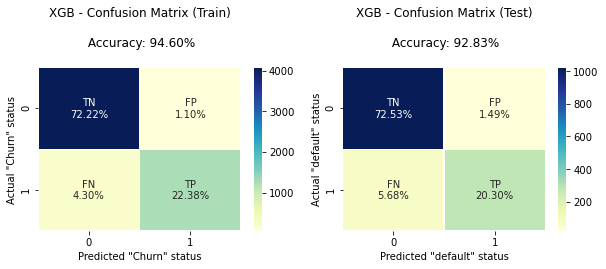

In [83]:
plot_cm(XGB_y_train,XGB_pred_train,XGB_y_test,XGB_pred_test,model_name="XGB - ")

### XGBoost (Modified)

In [95]:
threshold = 15 
feature_selected = RF_feature_impt.head(threshold).index.tolist()

XGB2_X = data_XGB[feature_selected]
XGB2_y = data_XGB['Churn']
XGB2_X_train, XGB2_X_test, XGB2_y_train, XGB2_y_test = train_test_split(XGB2_X, XGB2_y, train_size=0.8,
                                                                                                random_state=2022)

XGB2_model = GradientBoostingClassifier()
XGB2_model.fit(XGB2_X_train, XGB2_y_train)
XGB2_pred_train = XGB2_model.predict(XGB2_X_train)
XGB2_pred_test = XGB2_model.predict(XGB2_X_test)     

XGB2_train_acc, XGB2_test_acc = get_cm_accuracy(XGB2_y_train,XGB2_pred_train,XGB2_y_test,XGB2_pred_test)

Train set accuracy (in%): 77.97%
Test set accuracy (in%): 77.93%



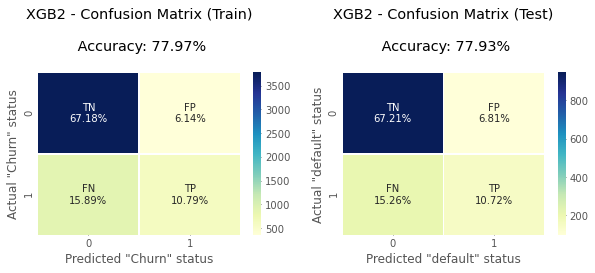

In [96]:
plot_cm(XGB2_y_train,XGB2_pred_train,XGB2_y_test,XGB2_pred_test,model_name="XGB2 - ")

<p style="color:firebrick;font-weight: bold"> ^^Here, we see that feature selection by RF did not improve the performance</p>


### Neural Network

In [103]:
data_NN = data_encoded.copy()
data_NN = data_NN.drop(geographical_col,axis=1)
data_NN = data_NN.replace("No internet service",0)
data_NN = data_NN.replace("No phone service",0)

In [104]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

NN_X = data_NN[independent_var]
NN_y = data_NN['Churn']
NN_X_train, NN_X_test, NN_y_train, NN_y_test = train_test_split(NN_X, NN_y, train_size=0.8,
                                                                                                random_state=2022)
# Normalization 
scaler = StandardScaler()
scaler.fit(NN_X_train)
NN_X_train = scaler.transform(NN_X_train)
NN_X_test = scaler.transform(NN_X_test)


NN_model = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
NN_model.fit(NN_X_train, NN_y_train.values.ravel())
NN_pred_train = NN_model.predict(NN_X_train)
NN_pred_test = NN_model.predict(NN_X_test)  

NN_train_acc, NN_test_acc = get_cm_accuracy(NN_y_train,NN_pred_train,NN_y_test,NN_pred_test)

Train set accuracy (in%): 99.25%
Test set accuracy (in%): 96.81%



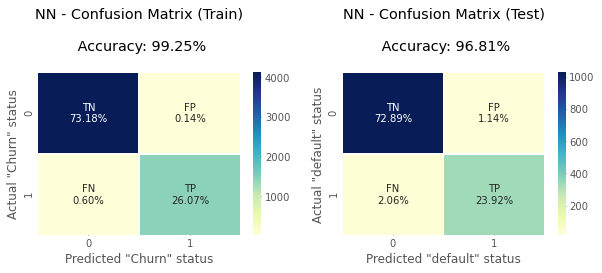

In [105]:
plot_cm(NN_y_train,NN_pred_train,NN_y_test,NN_pred_test,model_name="NN - ")

---

In [117]:
# Accuracy Table 
models = ['Logistic Regression','Random Forest', 'XGBoost','XGBoost(Modified)','Neural Network']
results_df = pd.DataFrame(index=models,columns=["train_accuracy","test_accuracy"])
results_df.loc['Logistic Regression']=[LR_train_acc,LR_test_acc]
results_df.loc['Random Forest']=[RF_train_acc,RF_test_acc]
results_df.loc['XGBoost']=[XGB_train_acc,XGB_test_acc]
results_df.loc['XGBoost(Modified)']=[XGB2_train_acc,XGB2_test_acc]
results_df.loc['Neural Network']=[NN_train_acc,NN_test_acc]

results_df = results_df.sort_values(by='test_accuracy',ascending=False)
results_df

,train_accuracy,test_accuracy
Neural Network,0.992545,0.968062
XGBoost,0.946042,0.928318
Random Forest,1,0.904897
Logistic Regression,0.787007,0.79489
XGBoost(Modified),0.77973,0.779276


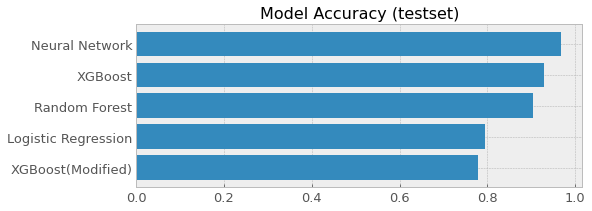

In [158]:
plot_barh( results_df,
                column_to_plot = 'test_accuracy',
                title = "Model Accuracy (testset)",
                figsize=(8,3),
                title_size=16,
                label_size=13,
                style="bmh"
         )